# Explorative study on attenuation densities in the lungs

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import *


In [2]:
%%capture
# Import from different folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_preprocess_dir = os.path.join(parent_dir, "DataPreprocess")

sys.path.append(data_preprocess_dir)
from main_preprocess import load_nifti_convert_to_numpy

In [3]:
# Define paths
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'
cropped_lung_ct_path = data_path + '/cropped_lungs_ct/*.nii.gz'
file_paths = glob.glob(cropped_lung_ct_path)

### Load data of attenuation arrays with vessels

In [4]:
# List the files in the attenuation directory
rows = []
for path in file_paths:
    arr = load_nifti_convert_to_numpy(input_path=path).flatten()
    arr = arr[arr > -4000]
    patient_id = os.path.basename(path)[7:10]
    new_row = {
        'attenuation': arr,
        'patient': patient_id,
        'label': 'w_ggo' if int(patient_id) < 14 else 'wo_ggo',
        'average_attenuation': np.mean(arr),
        'hpdr': get_hpdr(arr),
    }
    rows.append(new_row)

In [5]:
df = pd.DataFrame(rows).sort_values('patient')
df = df.reset_index(drop=True)

# Investigating attenuation

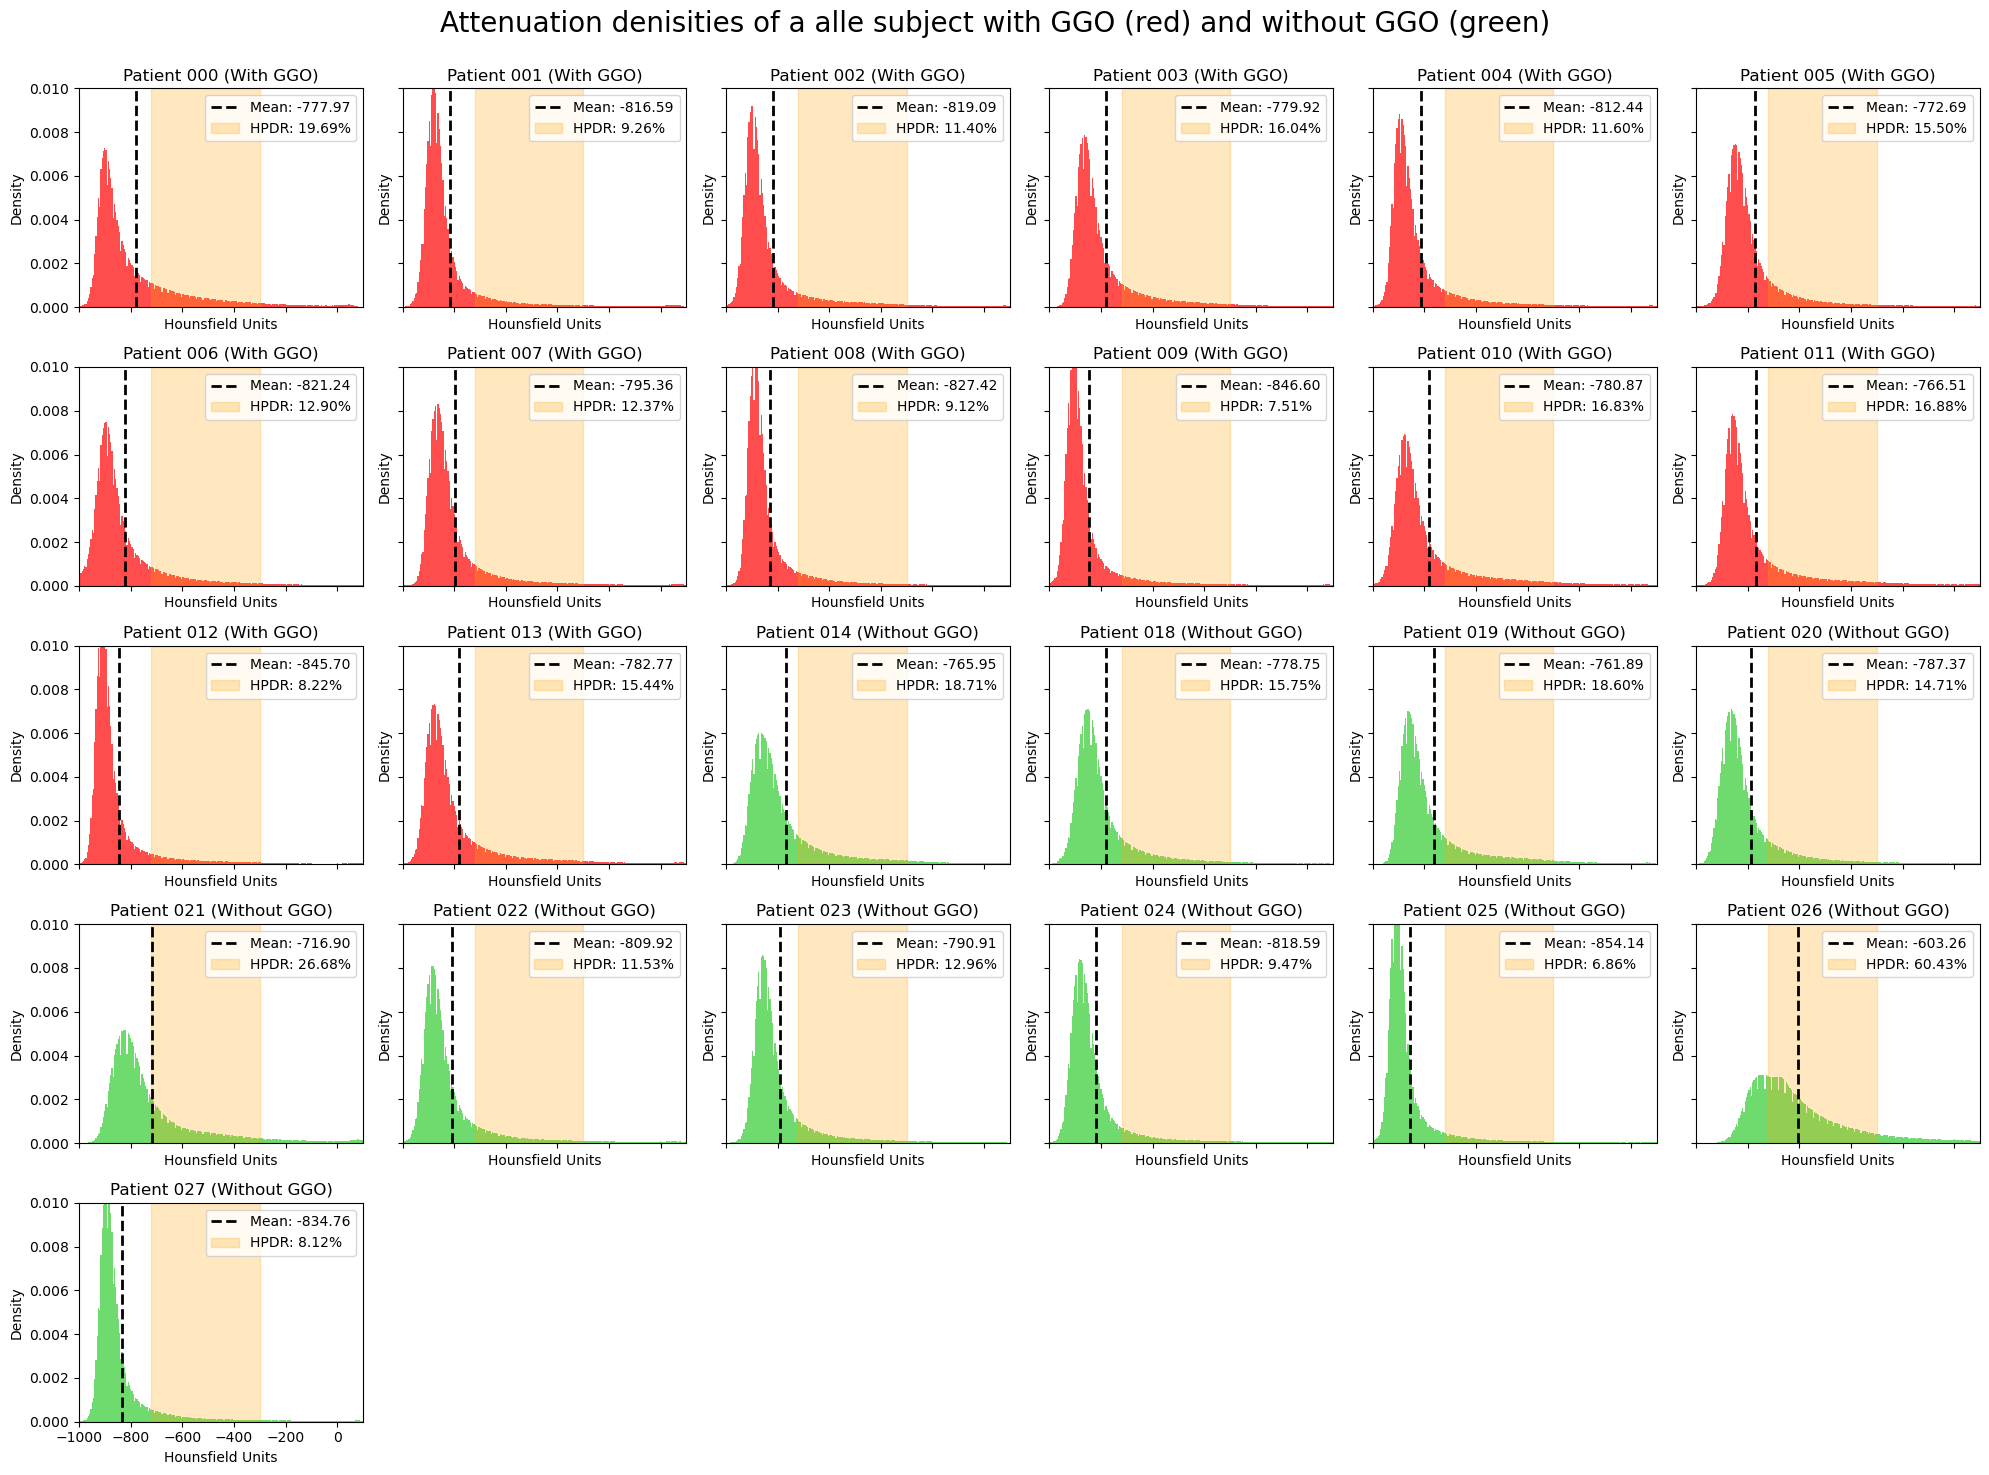

In [16]:
# Calculate the number of plots required (5 columns per row)
total_patients = df.shape[0]
cols = df.shape[1]
rows = (total_patients + cols - 1) // cols  # Round up to nearest whole row

# Create a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()
bins = np.linspace(-1000, 200, 250)
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'red' if label == 'w_ggo' else 'limegreen'
    title = 'With GGO' if label == 'w_ggo' else 'Without GGO'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({title})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, 100)
    HPDR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    #ax.legend([f'Mean: {mean_value:.2f}', f"HPDR: {hpdr_percent * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('Attenuation denisities of a alle subject with GGO (red) and without GGO (green)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

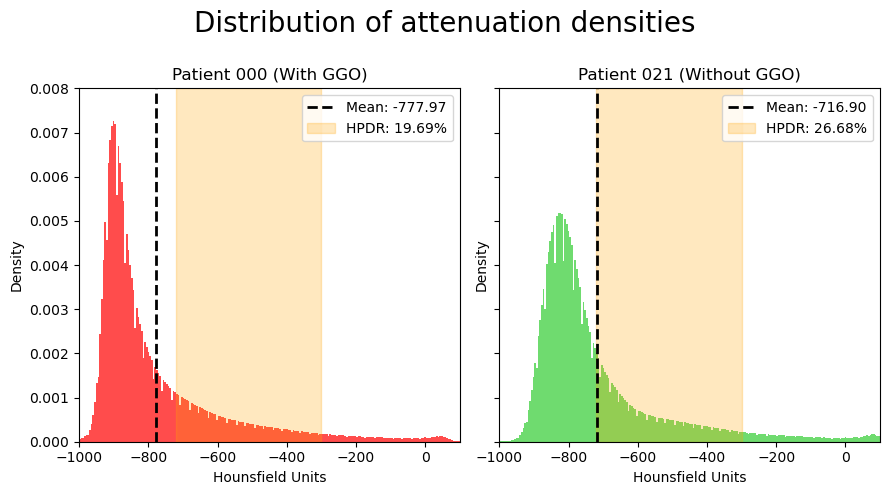

In [29]:
df_subset = df.iloc[[0, 18]]

cols = 2
rows = 1

# Create a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(9, 5), sharex=True, sharey=True)
axes = axes.flatten()
bins = np.linspace(-1000, 200, 250)
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df_subset.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'red' if label == 'w_ggo' else 'limegreen'
    title = 'With GGO' if label == 'w_ggo' else 'Without GGO'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({title})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.008)
    axes[subplot_idx].set_xlim(-1000, 100)
    HPDR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    #ax.legend([f'Mean: {mean_value:.2f}', f"HPDR: {hpdr_percent * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('Distribution of attenuation densities', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Distribution of average attenuations and HPDR (boxplots)

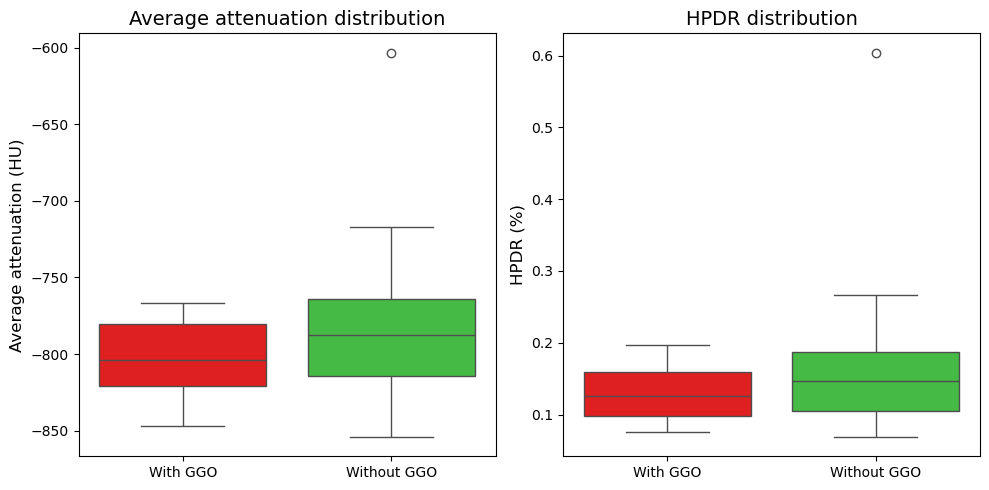

In [27]:
# Define colors and labels
custom_palette = {'Without GGO': 'limegreen', 'With GGO': 'red'}

# Create a copy of the dataframe with labels mapped for prettier x-axis
df['Group'] = df['label'].map({'wo_ggo': 'Without GGO', 'w_ggo': 'With GGO'})

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot: attenuation
sns.boxplot(
    data=df,
    x='Group',  # Use 'Group' for x-axis
    y='average_attenuation',
    hue='Group',  # Assign 'Group' to hue
    palette=custom_palette,
    ax=ax1,
    legend=False  # Disable the legend
)
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Average attenuation (HU)', fontsize=12)
ax1.set_title('Average attenuation distribution', fontsize=14)

# Boxplot: HPDR
sns.boxplot(
    data=df,
    x='Group',
    y='hpdr',
    hue='Group', 
    palette=custom_palette,
    ax=ax2,
    legend=False  # Disable the legend
)
ax2.set_xlabel('', fontsize=12)
ax2.set_ylabel('HPDR (%)', fontsize=12)
ax2.set_title('HPDR distribution', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
from scipy.stats import ttest_ind, mannwhitneyu

# Split the data into two groups for both metrics
group_wo_ggo_attenuation = df[df['label'] == 'wo_ggo']['average_attenuation']
group_w_ggo_attenuation = df[df['label'] == 'w_ggo']['average_attenuation']

group_wo_ggo_hpdr = df[df['label'] == 'wo_ggo']['hpdr']
group_w_ggo_hpdr = df[df['label'] == 'w_ggo']['hpdr']

# Perform Independent Samples t-test
t_stat_attenuation, p_value_attenuation = ttest_ind(group_wo_ggo_attenuation, group_w_ggo_attenuation, equal_var=False)
t_stat_hpdr, p_value_hpdr = ttest_ind(group_wo_ggo_hpdr, group_w_ggo_hpdr, equal_var=False)

# Perform Mann-Whitney U Test
u_stat_attenuation, p_u_attenuation = mannwhitneyu(group_wo_ggo_attenuation, group_w_ggo_attenuation, alternative='two-sided')
u_stat_hpdr, p_u_hpdr = mannwhitneyu(group_wo_ggo_hpdr, group_w_ggo_hpdr, alternative='two-sided')

# Print the results
print("Statistical Tests Results:")
print(f"Attenuation (t-test): t-statistic = {t_stat_attenuation:.3f}, p-value = {p_value_attenuation:.3e}")
print(f"Attenuation (Mann-Whitney U): U-statistic = {u_stat_attenuation:.3f}, p-value = {p_u_attenuation:.3e}")
print(f"HPDR (t-test): t-statistic = {t_stat_hpdr:.3f}, p-value = {p_value_hpdr:.3e}")
print(f"HPDR (Mann-Whitney U): U-statistic = {u_stat_hpdr:.3f}, p-value = {p_u_hpdr:.3e}")


Statistical Tests Results:
Attenuation (t-test): t-statistic = 1.306, p-value = 2.153e-01
Attenuation (Mann-Whitney U): U-statistic = 97.000, p-value = 2.857e-01
HPDR (t-test): t-statistic = 1.182, p-value = 2.623e-01
HPDR (Mann-Whitney U): U-statistic = 90.000, p-value = 4.938e-01
